# Planar data classification with one hidden layer

Welcome to your week 3 programming assignment. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression. 

**You will learn how to:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation


## 1 - Packages ##

Let's first import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [sklearn](http://scikit-learn.org/stable/) provides simple and efficient tools for data mining and data analysis. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
- testCases provides some test examples to assess the correctness of your functions
- planar_utils provide various useful functions used in this assignment

In [62]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
# from planar_utils import plot_decision_boundary, sigmoid, load_extra_datasets

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

In [63]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400
    N = int(m / 2)
    D = 2
    X = np.zeros((m, D))
    Y = np.zeros((m, 1), dtype = "uint8")
    a = 4
    
    for j in range(2):
        ix = range(N * j, N * (j + 1))
        t = np.linspace(j * 3.12, (j + 1) * 3.12, N) + np.random.randn(N) * 0.2
        r = a * np.sin(4 * t) + np.random.randn(N) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        Y[ix] = j
        
    # X = X.T
    # Y = Y.T
    # 和大部分开源框架保持一致,样本数量做行，而特征数量作为列
    return X,Y

## 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [64]:
X, Y = load_planar_dataset()

In [65]:
X.shape

(400, 2)

In [66]:
Y.shape

(400, 1)

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

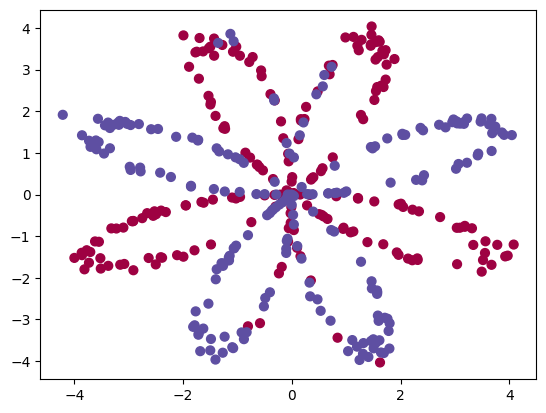

In [67]:
# Visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=Y[:, 0], s=40, cmap=plt.cm.Spectral);

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

**Hint**: How do you get the shape of a numpy array? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [68]:
### START CODE HERE ### (≈ 3 lines of code)
shape_X = X.shape
shape_Y = Y.shape
m = X.shape[0]  # training set size
### END CODE HERE ###

print (f'The shape of X is: {shape_X}')
print (f'The shape of Y is: {shape_Y}')
print (f'I have m = {m} training examples!')

The shape of X is: (400, 2)
The shape of Y is: (400, 1)
I have m = 400 training examples!


**Expected Output**:
       
<table style="width:20%">
  
  <tr>
    <td>**shape of X**</td>
    <td> (400, 2) </td>
  </tr>
  
  <tr>
    <td>**shape of Y**</td>
    <td>(400, 1) </td>
  </tr>
  
    <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

## 3 - Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. Run the code below to train a logistic regression classifier on the dataset.

In [69]:
# Train the logistic regression classifier
model = LogisticRegression()
model.fit(X, Y[:, 0])

LogisticRegression()

You can now plot the decision boundary of these models. Run the code below.

In [70]:
def plot_decision_boundary(model, X, y):
    """
    可视化分类模型的决策边界。

    参数:
    model: 训练好的分类模型，具有可调用的预测方法。
    X: 输入特征，形状为 (2, n_samples)，其中 n_samples 是样本数量。
       X 的第一行表示第一个特征，第二行表示第二个特征。
    y: 标签，形状为 (n_samples,)，表示每个样本的类别。

    返回值:
    None: 该函数直接绘制决策边界和训练样本，不返回任何值。
    """

    # 设置特征的最小值和最大值，并留出一些边距
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1  # 第一个特征的范围
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1  # 第二个特征的范围
    h = 0.01  # 网格的步长

    # 生成一个网格点，步长为 h
    # xx 表示网格中每个点的x坐标
    # yy 表示网格中每个点的y坐标
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # 对整个网格预测模型的输出值
    Z = model(np.c_[xx.ravel(), yy.ravel()])  # 将 xx 和 yy 转换为模型的输入格式
    # 将预测结果调整为与网格形状相同
    Z = Z.reshape(xx.shape)

    # 绘制决策边界的等高线图，并显示训练样本
    # @xx, @yy这两个参数通常是通过 np.meshgrid 生成的二维数组，分别表示网格点的 x 坐标和 y 坐标。
    # @ Z 一个二维数组，表示在每个 (xx, yy) 网格点上的值。这个值通常是要绘制的函数的输出。
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)  # 绘制决策边界
    plt.ylabel('x2')  # 设置 y 轴标签
    plt.xlabel('x1')  # 设置 x 轴标签
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)  # 绘制训练样本，点的颜色根据其类别

Text(0.5, 1.0, 'Logistic Regression')

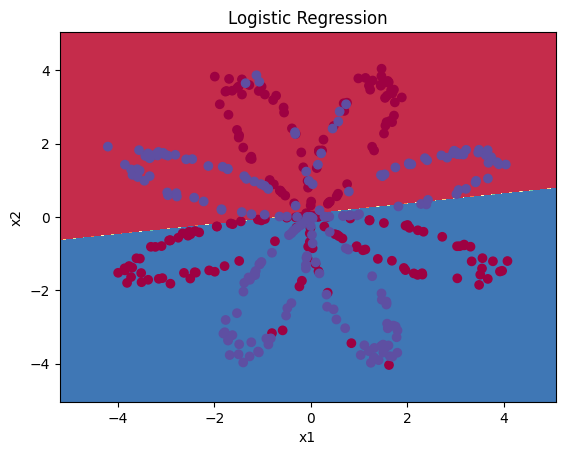

In [71]:
plot_decision_boundary(lambda x: model.predict(x), X, Y[:, 0])
plt.title("Logistic Regression")

In [72]:
LR_predictions = model.predict(X)
print(f"LR_predictions.shape: {LR_predictions.shape}")
train_accuracy = np.mean(LR_predictions == Y) * 100
print(f"Accuracy of logistic regression: {train_accuracy} % (percentage of correctly labelled datapoints)")

LR_predictions.shape: (400,)
Accuracy of logistic regression: 50.0 % (percentage of correctly labelled datapoints)


**Expected Output**:

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

## 4 - Neural Network model

Logistic regression did not work well on the "flower dataset". You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### 4.1 - Defining the neural network structure ####

**Exercise**: Define three variables:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [73]:
def layer_sizes(X, units, Y):
    """
    确定神经网络各层的大小。

    参数：
    X (numpy.ndarray): 输入特征数据，形状为 (m, n_x)
                       其中 n_x 是特征数量，m 是样本数量。
    Y (numpy.ndarray): 输出标签数据，形状为 (m, n_y)，
                       其中 n_y 是输出类别数量，m 是样本数量。
    units (int): 隐藏层中神经元的数量，可以是一个整数，
                  表示单个隐藏层的单元数。

    返回值：
    tuple: 返回一个元组 (n_x, n_y, units)，
           其中 n_x 是输入层的大小（特征数量），
           n_y 是输出层的大小（类别数量），
           units 是隐藏层的单元数量。
    """

    n_x = X.shape[1]  # 获取输入特征的数量，作为输入层的大小
    n_y = Y.shape[1]  # 获取输出类别的数量，作为输出层的大小
    # 返回输入层特征数、隐藏层神经元数量, 输出层特征数
    return n_x, units, n_y,

In [74]:
def layer_sizes_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 5)
    Y_assess = np.random.randn(3, 2)
    return X_assess, Y_assess

In [75]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, units, n_y) = layer_sizes(X_assess, 4, Y_assess)
print(f"The size of the input layer is: n_x = {n_x}")
print(f"The size of the hidden layer is: n_h = {units}")
print(f"The size of the output layer is: n_y = {n_y}")

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Expected Output** (these are not the sizes you will use for your network, they are just used to assess the function you've just coded).

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
  
    <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  
    <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### 4.2 - Initialize the model's parameters ####

**Exercise**: Implement the function `initialize_parameters()`.
**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [76]:
# GRADED FUNCTION: initialize_parameters
def initialize_parameters(n_x, units, n_y):
    """
    初始化神经网络的参数。

    参数:
    n_x (int): 输入层的特征数量，即输入数据的维度。
    units (int): 隐藏层神经元的数量。
    n_y (int): 输出层的神经元数量，即输出数据的维度。

    返回:
    dict: 包含初始化参数的字典，字典中包括：
        - W1 (numpy.ndarray): 隐藏层的权重参数，形状为 (n_x, units)。
        - b1 (numpy.ndarray): 隐藏层的偏置参数，形状为 (units, 1)。
        - W2 (numpy.ndarray): 输出层的权重参数，形状为 (units, n_y)。
        - b2 (numpy.ndarray): 输出层的偏置参数，形状为 (n_y, 1)。
    """
    np.random.seed(2)  # 设置随机种子以保证结果可复现

    # W1 代表隐藏层输入W的参数,形状为(n_x, units)
    W1 = np.random.randn(n_x, units) * 0.01  # 初始化权重
    b1 = np.zeros(units)  # 初始化偏置

    assert (W1.shape == (n_x, units))  # 确保 W1 形状正确
    # assert (b1.shape == (units, 1))  # 确保 b1 形状正确

    # W2 代表输出层的W权重参数
    W2 = np.random.randn(units, n_y) * 0.01  # 初始化权重
    b2 = np.zeros(n_y)  # 初始化偏置

    assert (W2.shape == (units, n_y))  # 确保 W2 形状正确
    # assert (b2.shape == (n_y, 1))  # 确保 b2 形状正确

    # 将所有参数存储在字典中
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}

    return parameters  # 返回初始化的参数字典

In [77]:
def initialize_parameters_test_case():
    n_x, units, n_y = 2, 4, 1
    return n_x, units, n_y

In [78]:
n_x, units, n_y = initialize_parameters_test_case()
parameters = initialize_parameters(n_x, units, n_y)
W1 = parameters["W1"]
b1 = parameters["b1"]
W2 = parameters["W2"]
b2 = parameters["b2"]

print(f"W1 = {W1}")
print(f"b1 = {b1}")
print(f"W2 = {W2}")
print(f"b2 = {b2}")

W1 = [[-0.00416758 -0.00056267 -0.02136196  0.01640271]
 [-0.01793436 -0.00841747  0.00502881 -0.01245288]]
b1 = [0. 0. 0. 0.]
W2 = [[-0.01057952]
 [-0.00909008]
 [ 0.00551454]
 [ 0.02292208]]
b2 = [0.]


**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td>
    [[-0.00416758 -0.00056267 -0.02136196  0.01640271]
     [-0.01793436 -0.00841747 0.00502881 -0.01245288]]
    </td>
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952]
          [-0.00909008]
          [0.00551454]
          [0.02292208]]
    </td>
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### 4.3 - The Loop ####

**Question**: Implement `forward_propagation()`.

**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `sigmoid()`. It is built-in (imported) in the notebook.
- You can use the function `np.tanh()`. It is part of the numpy library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [79]:
def sigmoid(Z):
    """
    计算输入 Z 的 sigmoid 激活函数。

    参数:
    Z (numpy.ndarray): 输入值，可以是标量、向量或矩阵，表示神经元的加权输入。

    返回:
    numpy.ndarray: 输入 Z 经过 sigmoid 激活函数处理后的输出，范围在 (0, 1) 之间。
    """
    return 1 / (1.0 + np.exp(-1 * Z))  # 应用 sigmoid 函数公式

In [80]:
def plot_sigmoid():
    # 生成输入值
    Z = np.linspace(-10, 10, 100)  # 从 -10 到 10 生成 100 个点
    # 计算 sigmoid 值
    A = sigmoid(Z)
    # 绘制 sigmoid 函数图像
    plt.figure(figsize=(8, 5))
    plt.plot(Z, A, label='sigmoid function', color='blue')
    plt.title('Sigmoid Function')
    plt.xlabel('Input (Z)')
    plt.ylabel('Output (sigmoid(Z))')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()
    plt.legend()
    plt.xlim(-10, 10)
    plt.ylim(-0.1, 1.1)
    plt.show()

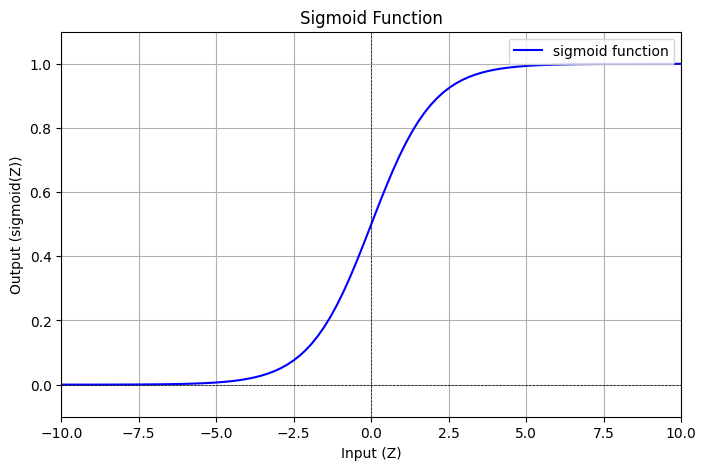

In [81]:
plot_sigmoid()

In [82]:
def plot_tanh():
    # 生成输入值
    Z = np.linspace(-10, 10, 100)  # 从 -10 到 10 生成 100 个点
    # 计算 tanh 值
    A = np.tanh(Z)
    # 绘制 tanh 函数图像
    plt.figure(figsize=(8, 5))
    plt.plot(Z, A, label='tanh function', color='orange')
    plt.title('Tanh Function')
    plt.xlabel('Input (Z)')
    plt.ylabel('Output (tanh(Z))')
    plt.axhline(0, color='black', lw=0.5, ls='--')
    plt.axvline(0, color='black', lw=0.5, ls='--')
    plt.grid()
    plt.legend()
    plt.xlim(-10, 10)
    plt.ylim(-1.1, 1.1)
    plt.show()

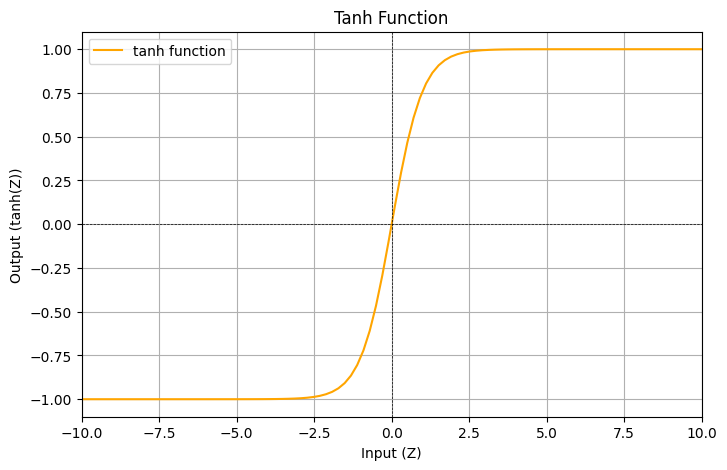

In [83]:
plot_tanh()

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

In [84]:
# GRADED FUNCTION: forward_propagation
def forward_propagation(X, parameters):
    """
    执行前向传播，计算神经网络的输出。

    参数:
    X (numpy.ndarray): 输入数据，形状为 (m, n)，其中 m 是样本数量，n 是特征数量。
    parameters (dict): 包含神经网络参数的字典，包括 W1, b1, W2, b2。

    返回:
    tuple: 包含两个元素的元组：
        - A2 (numpy.ndarray): 输出层的激活值，形状为 (m, n_y)，表示每个样本的预测值。
        - cache (dict): 包含中间计算结果的字典，用于反向传播，包含 Z1, A1, Z2, A2。
    """
    m = X.shape[0]  # 样本数量

    W1 = parameters["W1"]  # 隐藏层的权重
    b1 = parameters["b1"]  # 隐藏层的偏置
    # print(f"X.shape:{X.shape}", f"W1.shape:{W1.shape}", f"b1.shape:{b1.shape}")

    # 计算隐藏层的线性组合
    # (m, n) @ (n, units)=>(m, units)
    Z1 = X @ W1 + b1  # 形状为 (m, units)
    A1 = np.tanh(Z1)  # 应用 tanh 激活函数，形状为 (m, units)

    W2 = parameters["W2"]  # 输出层的权重
    b2 = parameters["b2"]  # 输出层的偏置
    # print(f"A1.shape:{A1.shape}", f"W2.shape:{W2.shape}", f"b2.shape:{b2.shape}")

    # 计算输出层的线性组合
    # (m, units) @ (units, 1)
    Z2 = A1 @ W2 + b2  # 形状为 (m, 1)
    A2 = sigmoid(Z2)  # 应用 sigmoid 激活函数，形状为 (m, 1)

    # 确保 A2 形状正确
    assert(A2.shape == (m, 1))

    # 将中间结果存储在缓存中
    # 缓存的结果用于梯度下降中的反向传播求导
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}

    # 返回输出和缓存
    return A2, cache

In [85]:
def forward_propagation_test_case():
    """
    创建前向传播的测试用例。

    返回:
    tuple: 包含两个元素的元组：
        - X_assess (numpy.ndarray): 输入数据，形状为 (3, 2)，表示 3 个样本，每个样本有 2 个特征。
        - parameters (dict): 包含神经网络参数的字典，包括 W1, W2, b1, b2。
    """
    np.random.seed(1)  # 设置随机种子以确保结果可重复

    # 生成输入数据 (3, 2)
    X_assess = np.random.randn(3, 2)

    # 隐藏层偏置 (4, 1)，隐藏层有 4 个神经元
    b1 = np.random.randn(4)

    # 输出层偏置 (1, 1)
    b2 = np.array([-1.3])

    # (4, 2)
    W1 = np.array([[-0.00416758, -0.00056267],
        [-0.02136196,  0.01640271],
        [-0.01793436, -0.00841747],
        [ 0.00502881, -0.01245288]])
    # (1, 4)
    W2 = np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]])
    # 权重 W1 (2, 4)，输入层到隐藏层的权重
    parameters = {
        'W1': W1.T,
        # 权重 W2 (4, 1)，隐藏层到输出层的权重
        'W2': W2.T,
        'b1': b1,  # 隐藏层偏置
        'b2': b2   # 输出层偏置
    }
    print(f"W1.shape:{parameters['W1'].shape}", f"b1.shape:{parameters['b1'].shape}")
    print(f"W2.shape:{parameters['W2'].shape}", f"b2.shape:{parameters['b2'].shape}")

    Y_assess = (np.random.randn(3, 1) > 0)
    # 返回输入数据和参数字典
    return X_assess, Y_assess, parameters

In [86]:
X_assess, Y_assess, parameters = forward_propagation_test_case()
print(f"X_assess.shape:{X_assess.shape}", f"Y_assess.shape:{Y_assess.shape}")

W1.shape:(2, 4) b1.shape:(4,)
W2.shape:(4, 1) b2.shape:(1,)
X_assess.shape:(3, 2) Y_assess.shape:(3, 1)


In [87]:
A2, cache = forward_propagation(X_assess, parameters)
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

0.25870661187423427 0.09021914622807749 -1.3074030962417396 0.2129217287725367


**Expected Output**:
<table style="width:50%">
  <tr>
    <td> 0.2729544712900037 0.09476324162626719 -1.30761222714781 0.21288668227518423 </td>
  </tr>
</table>

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

$$J = -\frac{1}{m} \left( \mathbf{Y}^T \log ({\mathbf{A}}) + (1 - \mathbf{Y})^T \log(1 - {\mathbf{A}}) \right)$$

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss. To help you, we give you how we would have implemented
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(you can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`).


In [88]:
# GRADED FUNCTION: compute_cost
def compute_cost(A, Y):
    """
    计算逻辑回归的成本（损失）。

    参数:
    A (numpy.ndarray): 模型的预测值，形状为 (m, 1)，其中 m 是样本数量。
                       A 的值应在 0 到 1 之间，通常是经过 sigmoid 函数处理的输出。
    Y (numpy.ndarray): 实际标签，形状为 (m, 1)，表示每个样本的真实标签（0 或 1）。

    返回:
    float: 计算得到的成本（损失）值，表示模型预测与真实标签之间的差异。
    """
    m = Y.shape[0]  # 样本数量

    # 计算成本
    cost = (-1.0 / m) * (Y.T @ np.log(A) + (1 - Y).T @ np.log(1 - A))

    return cost  # 返回计算得到的成本


In [89]:
cost = compute_cost(A2, Y_assess)
cost.shape

(1, 1)

In [90]:
print(f"cost = {np.squeeze(cost)}")

cost = 0.6752797151669379


**Expected Output**:
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.6752135864700313... </td>
  </tr>
  
</table>


- 对于一个有n层隐藏层(不包括输出和输入)的求导规则如下
- 其中样本设计矩阵按照(m, n)来设计：
$$
\begin{align*}
d(Z^{[output]})
&= \frac{\partial L}{\partial Z^{[output]}} \\
&= A^{[output]} - Y
\end{align*}
$$

$$
\begin{align*}
d(W^{[output]})
&= \frac{\partial L}{\partial W^{[output]}} \\
&= \frac{1}{m} (A^{[n]})^T d(Z^{[output]})
\end{align*}
$$

$$
\begin{align*}
d(b^{[output]})
&= \frac{\partial L}{\partial b^{[output]}} \\
&= \frac{1}{m} \sum d(Z^{[output]}) \\
&= \frac{1}{m} \mathbf{1}^T d(Z^{[output]})
\end{align*}
$$

- n个隐藏层对于第k层的求导规则
$$
\begin{align*}
d(Z^{[k]})
&= \frac{\partial L}{\partial Z^{[k]}} \\
&= \frac{\partial L}{\partial Z^{[[k+1]}} (W^{[k+1]})^T \circ g^{[k]}{'}(Z^{[k]}) \\
&= d(Z^{[[k+1]}) (W^{[k+1]})^T \circ g^{[k]}{'}(Z^{[k]})
\end{align*}
$$
- 其中：$\quad \text{for } k = n, n-1, \ldots, 1$

$$
\begin{align*}
d(W^{[k]})
&= \frac{\partial L}{\partial W^{[k]}} \\
&= \frac{1}{m} (A^{[k-1]})^T d(Z^{[k]})
\end{align*}
$$
- 其中：$\quad \text{for } k = 1, 2, \ldots, n$

$$
\begin{align*}
d(b^{[k]})
&= \frac{\partial L}{\partial b^{[k]}} \\
&= \frac{1}{m} \sum d(Z^{[k]}) \\
&= \frac{1}{m} \mathbf{1}^T d(Z^{[k]})
\end{align*}
$$
- 其中：$\quad \text{for } k = 1, 2, \ldots, n$

- $W^{[output]}$是输出层的权重参数
- $g^{[k]}{'}(Z^{[k]})$是第k(1,2,...n)层隐藏层激活函数的导数,如$g^{[1]}{'}(Z^{[1]})$是第一层的激活函数的导数
- 假设激活函数$g^{[1]}(z^{[1]}) = 1/ (1 + e^{-z^{[1]}})$ = a则有$g^{[1]}{'}(z^{[1]}) = a(1-a) $
- 假设激活函数$g^{[1]}(z^{[1]}) = (e^{z^{[1]}} - e^{-z^{[1]}}) / (e^{z^{[1]}} + e^{-z^{[1]}})$ = a则有$g^{[1]}{'}(z^{[1]}) = 1-a^{2}$
- $\circ$ 表示哈达玛积（元素乘法）。

- 参数更新规则：
$$
W^{[output]} = W^{[output]} - \alpha \frac{\partial L}{\partial W^{[output]}}
$$

$$
b^{[output]} = b^{[output]} - \alpha \frac{\partial L}{\partial b^{[output]}}
$$

$$
W^{(k)} = W^{[k]} - \alpha \frac{\partial L}{\partial W^{[k]}}
$$

$$
b^{(k)} = b^{[k]} - \alpha \frac{\partial L}{\partial b^{[k]}}
$$

Using the cache computed during forward propagation, you can now implement backward propagation.

**Question**: Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$

!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [91]:
def backward_propagation_test_case():
    np.random.seed(1)

    # (3, 2)
    X_assess = np.random.randn(3, 2)
    # (3, 1)
    Y_assess = (np.random.randn(3, 1) > 0)
    parameters = {
        # W1 (2, 4)->2个特征,4个神经元
        'W1': np.array([ [-0.00416758, -0.00056267],
                    [-0.02136196,  0.01640271],
                    [-0.01793436, -0.00841747],
                    [ 0.00502881, -0.01245288] ]).T,
        # (4, )
        'b1': np.array([0., 0., 0., 0.]),
        # W2 (4, 1) 输出层输入有4个特征
        'W2': np.array([[-0.01057952, -0.00909008,  0.00551454,  0.02292208]]).T,
        # b2 (1, 1)
        'b2': np.array([0.])
    }

    cache = {
        # (3, 4)
        'A1': np.array(
                [[-0.00616578,  0.0020626 ,  0.00349619],
                [-0.05225116,  0.02725659, -0.02646251],
                [-0.02009721,  0.0036869 ,  0.02883756],
                [ 0.02152675, -0.01385234,  0.02599885]]).T,
        'A2': np.array([[ 0.5002307 ,  0.49985831,  0.50023963]]).T,
        'Z1': np.array([[-0.00616586,  0.0020626 ,  0.0034962 ],
             [-0.05229879,  0.02726335, -0.02646869],
             [-0.02009991,  0.00368692,  0.02884556],
             [ 0.02153007, -0.01385322,  0.02600471]]).T,
        'Z2': np.array([[ 0.00092281, -0.00056678,  0.00095853]]).T
    }
    return parameters, cache, X_assess, Y_assess

In [92]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

In [93]:
# GRADED FUNCTION: backward_propagation
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.

    Arguments:
    parameters -- python dictionary containing our parameters
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)

    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[0]
    print(f"X.shape:{X.shape}", f"Y.shape:{Y.shape}")

    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    # print(f"W1.shape:{W1.shape}", f"W2.shape:{W2.shape}")
    ### END CODE HERE ###

    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache["A1"]
    A2 = cache["A2"]
    print(f"A1.shape:{A1.shape}", f"A2.shape:{A2.shape}")
    ### END CODE HERE ###

    # Backward propagation: calculate dW1, db1, dW2, db2.
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    # (m, 1)
    dZ2 = A2 - Y
    dW2 = (A1.T @ dZ2 ) / m

    ones_vec = np.ones((dZ2.shape[0]))
    db2 = (ones_vec.T @ dZ2) / m
    print(f"dZ2.shape:{dZ2.shape}, "f"dW2.shape:{dW2.shape}", f"db2.shape:{db2.shape}")

    dZ1 = (dZ2 @ W2.T) * (1 - np.power(A1, 2))
    dW1 = (X.T @ dZ1) / m

    ones_vec = np.ones((dZ1.shape[0]))
    db1 = (ones_vec.T @ dZ1) / m
    ### END CODE HERE ###
    print(f"dZ1.shape:{dZ1.shape}, "f"dW1.shape:{dW1.shape}", f"db1.shape:{db1.shape}")

    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [94]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print (f"dW1 = {grads['dW1']}")
print (f"db1 = {grads['db1']}")
print (f"dW2 = {grads['dW2']}")
print (f"db2 = {grads['db2']}")

X.shape:(3, 2) Y.shape:(3, 1)
A1.shape:(3, 4) A2.shape:(3, 1)
dZ2.shape:(3, 1), dW2.shape:(4, 1) db2.shape:(1,)
dZ1.shape:(3, 4), dW1.shape:(4, 2) db1.shape:(4,)
dW1 = [[ 0.00531892 -0.00324297]
 [ 0.00456198 -0.00278272]
 [-0.00277127  0.00168846]
 [-0.011519    0.00702032]]
db1 = [ 0.00176201  0.00150995 -0.00091736 -0.00381422]
dW2 = [[ 0.00078841]
 [ 0.01765429]
 [-0.00084166]
 [-0.01022527]]
db2 = [-0.16655712]


**Expected output**:



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.00301023 -0.00747267]
 [ 0.00257968 -0.00641288]
 [-0.00156892  0.003893  ]
 [-0.00652037  0.01618243]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[ 0.00176201]
 [ 0.00150995]
 [-0.00091736]
 [-0.00381422]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00078841  0.01765429 -0.00084166 -0.01022527]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[-0.16655712]] </td> 
  </tr>
  
</table>  

**Question**: Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [95]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * grads["dW1"]
    b1 = b1 - learning_rate * grads["db1"]
    W2 = W2 - learning_rate * grads["dW2"]
    b2 = b2 - learning_rate * grads["db2"]
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [96]:
def update_parameters_test_case():
    parameters = {
        'W1': np.array(
            [[-0.00615039,  0.0169021 ],
            [-0.02311792,  0.03137121],
            [-0.0169217 , -0.01752545],
            [ 0.00935436, -0.05018221]]).T,
        'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]).T,
        'b1': np.array([ -8.97523455e-07, 8.15562092e-06, 6.04810633e-07,-2.54560700e-06]),
        'b2': np.array([9.14954378e-05])
    }

    grads = {
        'dW1': np.array(
            [[ 0.00023322, -0.00205423],
                [ 0.00082222, -0.00700776],
                [-0.00031831,  0.0028636 ],
                [-0.00092857,  0.00809933]]).T,
        'dW2': np.array([[ -1.75740039e-05,   3.70231337e-03,  -1.25683095e-03, -2.55715317e-03]]).T,
        'db1': np.array([ 1.05570087e-07, -3.81814487e-06, -1.90155145e-07, 5.46467802e-07]),
        'db2': np.array([ -1.08923140e-05])
    }
    return parameters, grads

In [97]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025 -0.02410458 -0.01653973  0.01046864]
 [ 0.01936718  0.03978052 -0.02096177 -0.05990141]]
b1 = [-1.02420756e-06  1.27373948e-05  8.32996807e-07 -3.20136836e-06]
W2 = [[-0.01041081]
 [-0.04463285]
 [ 0.01758031]
 [ 0.04747113]]
b2 = [0.00010457]


**Expected Output**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

### 4.4 - Integrate parts 4.1, 4.2 and 4.3 in nn_model() ####

**Question**: Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the previous functions in the right order.

In [98]:
# GRADED FUNCTION: nn_model
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, n_h, Y)[0]
    n_y = layer_sizes(X, n_h, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, np.squeeze(cost)))

    return parameters

In [99]:
def nn_model_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 2)
    Y_assess = (np.random.randn(3, 1) > 0)
    return X_assess, Y_assess

In [100]:
X_assess, Y_assess = nn_model_test_case()
parameters = nn_model(X_assess, Y_assess, 4, num_iterations=50000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

X.shape:(3, 2) Y.shape:(3, 1)
A1.shape:(3, 4) A2.shape:(3, 1)
dZ2.shape:(3, 1), dW2.shape:(4, 1) db2.shape:(1,)
dZ1.shape:(3, 4), dW1.shape:(4, 2) db1.shape:(4,)


ValueError: operands could not be broadcast together with shapes (2,4) (4,2) 

**Expected Output**:

<table style="width:90%">

<tr> 
    <td> 
        **cost after iteration 0**
    </td>
    <td> 
        0.692739
    </td>
</tr>

<tr> 
    <td> 
        <center> $\vdots$ </center>
    </td>
    <td> 
        <center> $\vdots$ </center>
    </td>
</tr>

  <tr>
    <td>**W1**</td>
    <td> [[-0.65848169  1.21866811]
 [-0.76204273  1.39377573]
 [ 0.5792005  -1.10397703]
 [ 0.76773391 -1.41477129]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.287592  ]
 [ 0.3511264 ]
 [-0.2431246 ]
 [-0.35772805]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-2.45566237 -3.27042274  2.00784958  3.36773273]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.20459656]] </td> 
  </tr>
  
</table>  

### 4.5 Predictions

**Question**: Use your model to predict by building predict().
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```

In [40]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2 > 0.5)
    ### END CODE HERE ###
    
    return predictions

In [41]:
def predict_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 2)
    parameters = {'W1': np.array([[-0.00615039,  0.0169021 ],
        [-0.02311792,  0.03137121],
        [-0.0169217 , -0.01752545],
        [ 0.00935436, -0.05018221]]).T,
     'W2': np.array([[-0.0104319 , -0.04019007,  0.01607211,  0.04440255]]).T,
     'b1': np.array([-8.97523455e-07,
          8.15562092e-06,
          6.04810633e-07,
         -2.54560700e-06]),
     'b2': np.array([  9.14954378e-05])}
    return parameters, X_assess

In [42]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 1.0


**Expected Output**: 


<table style="width:40%">
  <tr>
    <td>**predictions mean**</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.

Cost after iteration 0: 0.693142
Cost after iteration 1000: 0.285742
Cost after iteration 2000: 0.272007
Cost after iteration 3000: 0.263648
Cost after iteration 4000: 0.257530
Cost after iteration 5000: 0.229378
Cost after iteration 6000: 0.222807
Cost after iteration 7000: 0.219642
Cost after iteration 8000: 0.217450
Cost after iteration 9000: 0.215727


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

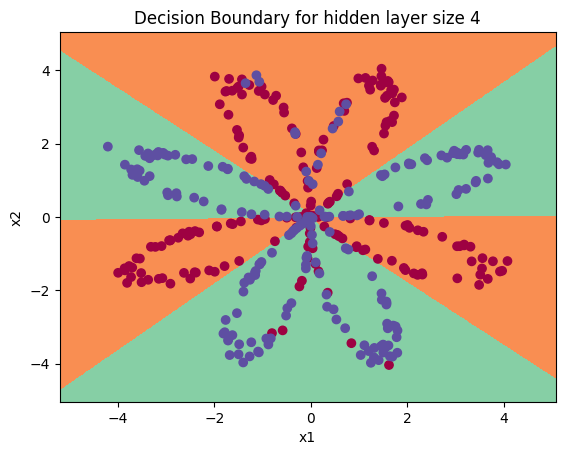

In [43]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x), X, Y[:, 0])
plt.title("Decision Boundary for hidden layer size " + str(4))

**Expected Output**:

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [44]:
# Print accuracy
predictions = predict(parameters, X)
train_accuracy = np.mean(predictions == Y) * 100
print(f"Accuracy of logistic regression: {train_accuracy} % (percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 90.75 % (percentage of correctly labelled datapoints)


**Expected Output**: 

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td> 
  </tr>
</table>

Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Now, let's try out several hidden layer sizes.

### 4.6 - Tuning hidden layer size (optional/ungraded exercise) ###

Run the following code. It may take 1-2 minutes. You will observe different behaviors of the model for various hidden layer sizes.

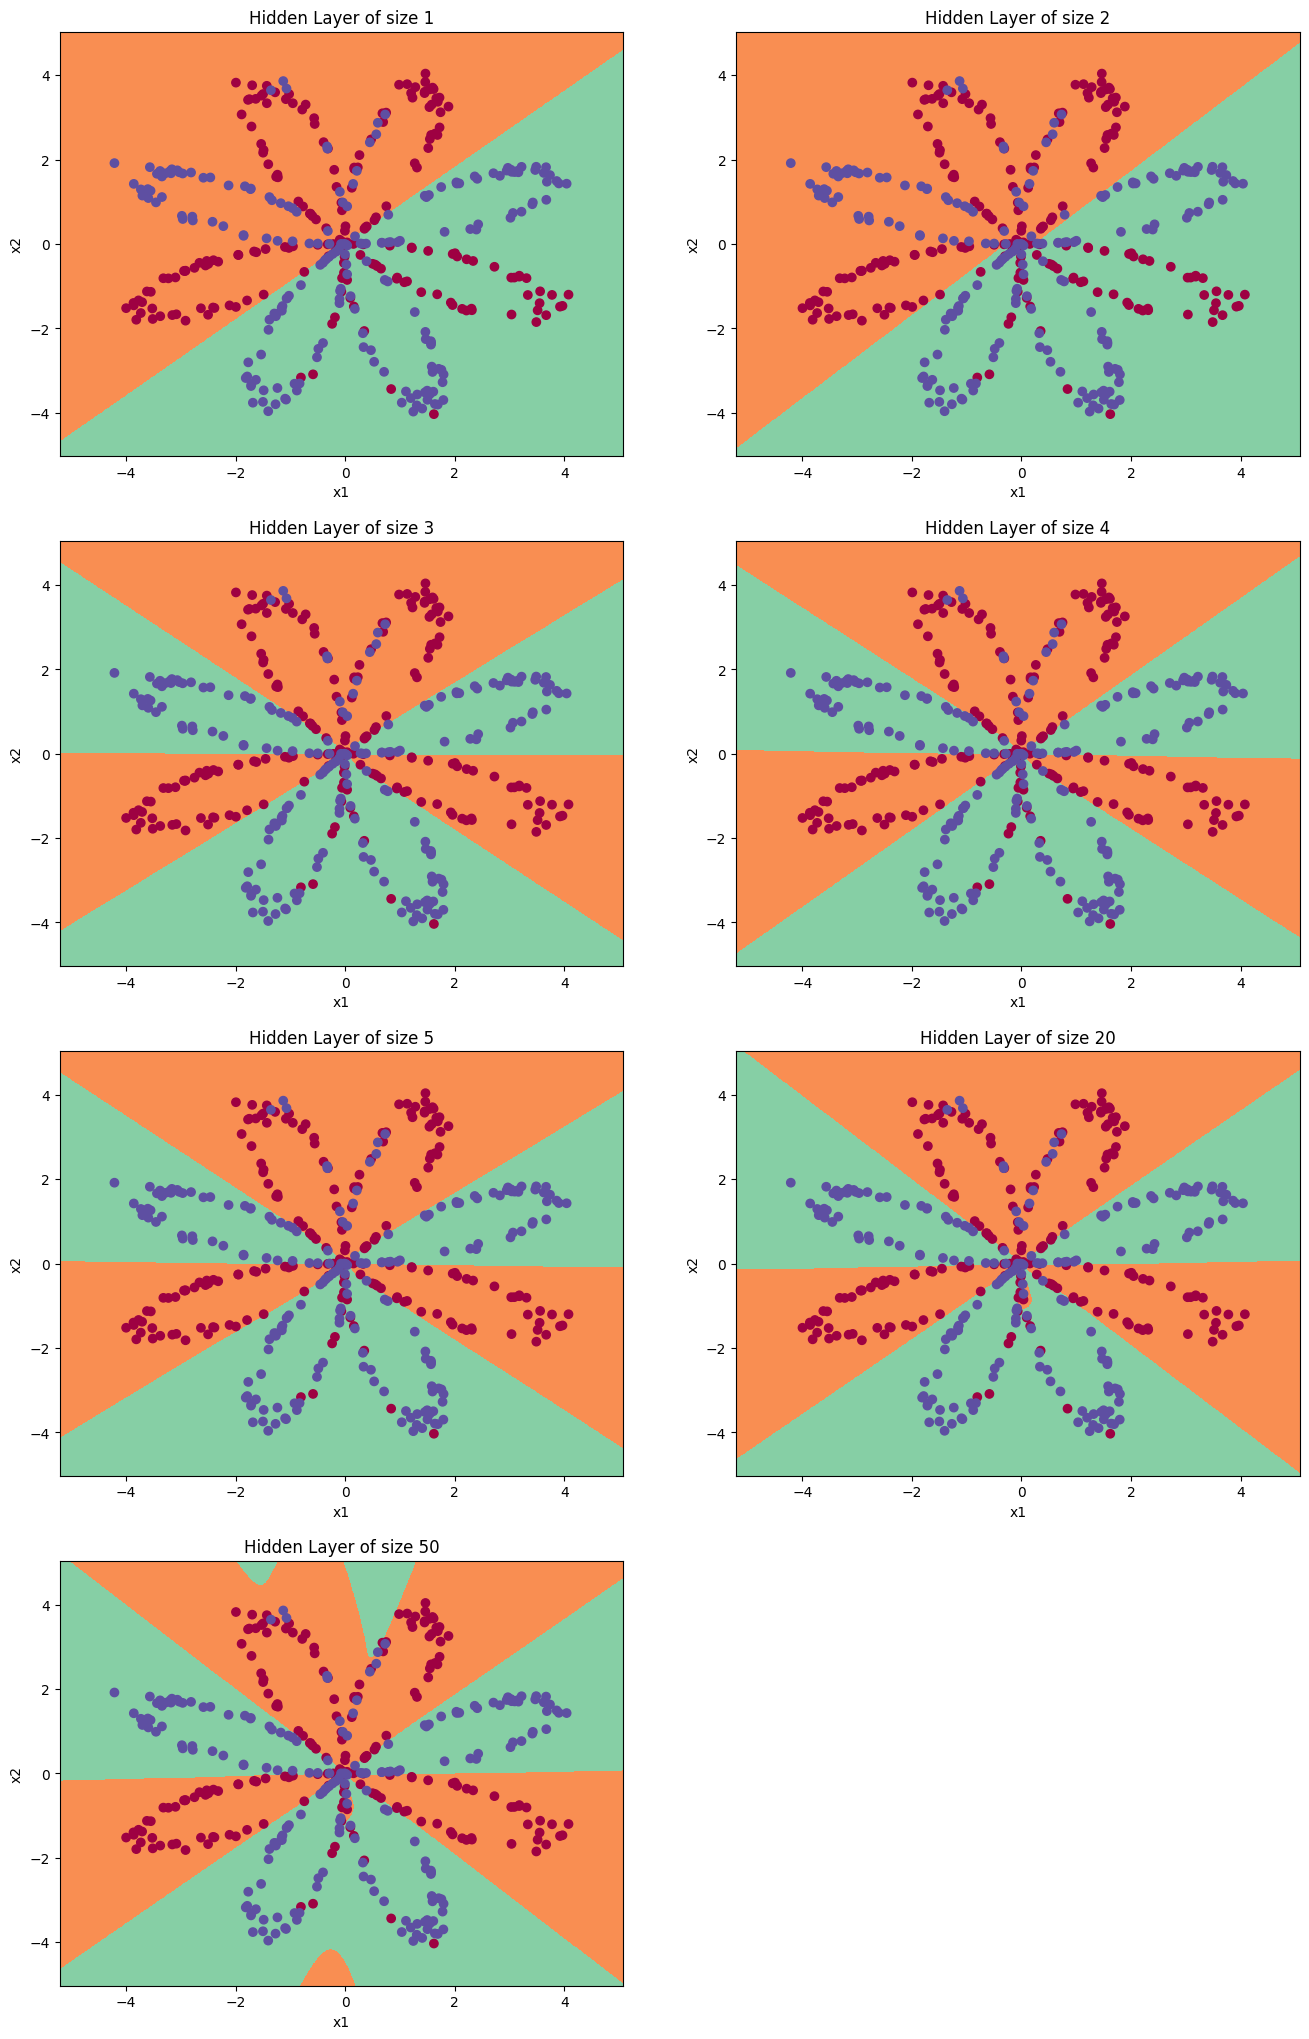

In [45]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x), X, Y[:, 0])
    predictions = predict(parameters, X)
    # accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    # print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticable overfitting.
- You will also learn later about regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

**Optional questions**:

**Note**: Remember to submit the assignment but clicking the blue "Submit Assignment" button at the upper-right. 

Some optional/ungraded questions that you can explore if you wish: 
- What happens when you change the tanh activation for a sigmoid activation or a ReLU activation?
- Play with the learning_rate. What happens?
- What if we change the dataset? (See part 5 below!)

<font color='blue'>
**You've learnt to:**
- Build a complete neural network with a hidden layer
- Make a good use of a non-linear unit
- Implemented forward propagation and backpropagation, and trained a neural network
- See the impact of varying the hidden layer size, including overfitting.

Nice work! 

## 5) Performance on other datasets

If you want, you can rerun the whole notebook (minus the dataset part) for each of the following datasets.

In [46]:
def load_extra_datasets():
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

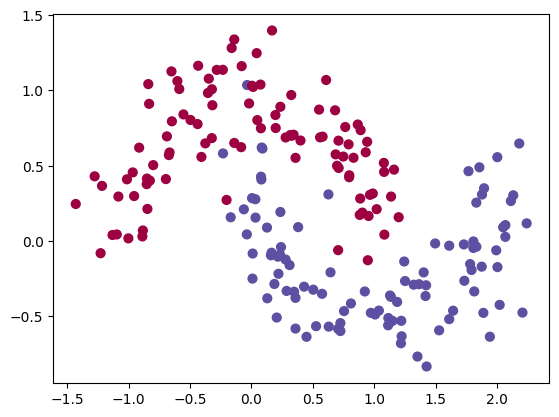

In [47]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral);

Congrats on finishing this Programming Assignment!

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/